In [8]:
import os
import pandas
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [9]:
# Custom Dataset
class DetectDataset(Dataset):
    def __init__(self, labels_dir, img_dir, transform=None, target_transform=None):
        self.labels_dir = labels_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        
    def __len__(self):
        return len(self.img_files)
        
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        
        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt'))
        label = self._load_label(label_path)
        
        # Apply transformations to image
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label
    
    # Helper function to get label from images
    def _load_label(self, label_path):
        # parse the label path and read files
        with open(label_path, 'r') as file:
            boxes = []
            for line in file.readlines():
                # Grab label variables from file
                class_id, x_center, y_center, width, height = map(float, line.strip().split()) # returns list of float from split line
                boxes.append([class_id, x_center, y_center, width, height])
        return torch.tensor(boxes)

In [10]:
# Variable Length Data: Each image can have a different number of bounding boxes. 
# The default collate_fn tries to stack everything into tensors, which fails if they have different shapes.

# Stack images into tensors but not targets to avoid this conflict
def collate_fn(batch):
    images = []
    targets = []
    for sample in batch:
        images.append(sample[0])
        targets.append(sample[1])
    images = torch.stack(images, dim=0)
    return images, targets

In [11]:
# class IDs
classes = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

In [12]:
train_labels_dir = "../data/VehiclesDetectionDataset/train/labels/"
train_img_dir = "../data/VehiclesDetectionDataset/train/images/"
test_labels_dir = "../data/VehiclesDetectionDataset/test/labels/"
test_img_dir = "../data/VehiclesDetectionDataset/test/images/"

In [13]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# load images dataset
trainset = DetectDataset(train_labels_dir, train_img_dir, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [14]:
# Calculate mean and std of image dataset
sum_ = torch.zeros(3)
sum_squared = torch.zeros(3)
num_images = 0

for images, _ in trainloader:
    sum_ += images.sum(dim=[0, 2, 3])
    sum_squared += (images ** 2).sum(dim=[0, 2, 3])
    num_images += images.size(0)

mean = sum_ / (num_images * images.size(2) * images.size(3))
std = (sum_squared / (num_images * images.size(2) * images.size(3)) - mean ** 2).sqrt()

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.4525, 0.4424, 0.4260])
Std: tensor([0.2787, 0.2777, 0.2892])


In [15]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [16]:
norm_trainset = DetectDataset(train_labels_dir, train_img_dir, transform=transform)
norm_trainloader = DataLoader(trainset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [17]:
testset = DetectDataset(test_labels_dir, test_img_dir, transform=transform)
testloader = DataLoader(testset, batch_size=8, shuffle=True)

In [47]:
train_features, train_labels = next(iter(norm_trainloader))

In [48]:
print(f"Feature shape: {train_features.shape}")
print(f"Feature shape: {train_labels.shape}")

Feature shape: torch.Size([4, 3, 416, 416])


AttributeError: 'list' object has no attribute 'shape'

In [19]:
train_features

tensor([[[[0.0000, 0.1059, 0.0510,  ..., 0.0039, 0.1333, 0.0118],
          [0.4667, 0.6627, 0.7451,  ..., 0.7725, 0.7765, 0.4667],
          [0.3765, 0.3804, 0.3686,  ..., 0.8667, 0.8510, 0.4588],
          ...,
          [0.4471, 0.7529, 0.7961,  ..., 0.5922, 0.5608, 0.4000],
          [0.4588, 0.7333, 0.7804,  ..., 0.7804, 0.6784, 0.4510],
          [0.0039, 0.1020, 0.0196,  ..., 0.0196, 0.0627, 0.0000]],

         [[0.0000, 0.1059, 0.0510,  ..., 0.0000, 0.1137, 0.0000],
          [0.4667, 0.6627, 0.7451,  ..., 0.7647, 0.7569, 0.4471],
          [0.3765, 0.3804, 0.3686,  ..., 0.8588, 0.8314, 0.4392],
          ...,
          [0.4392, 0.7451, 0.7882,  ..., 0.6078, 0.5765, 0.4196],
          [0.4510, 0.7255, 0.7725,  ..., 0.8000, 0.6980, 0.4706],
          [0.0000, 0.0941, 0.0118,  ..., 0.0392, 0.0824, 0.0078]],

         [[0.0078, 0.1137, 0.0588,  ..., 0.0157, 0.1373, 0.0157],
          [0.4745, 0.6627, 0.7529,  ..., 0.7843, 0.7804, 0.4706],
          [0.3765, 0.3725, 0.3686,  ..., 0

In [51]:
train_labels

[tensor([[2.0000, 0.4832, 0.5853, 0.9050, 0.4351],
         [2.0000, 0.9435, 0.5361, 0.1082, 0.1106]]),
 tensor([[2.0000, 0.1274, 0.2139, 0.2548, 0.2957],
         [2.0000, 0.3606, 0.4062, 0.7212, 0.6683],
         [2.0000, 0.2416, 0.0721, 0.1947, 0.1010],
         [2.0000, 0.5745, 0.2091, 0.1707, 0.1130],
         [2.0000, 0.8065, 0.2356, 0.2788, 0.2476],
         [2.0000, 0.9736, 0.2764, 0.0517, 0.1430]]),
 tensor([[1.0000, 0.4868, 0.4772, 0.7175, 0.6142],
         [1.0000, 0.8978, 0.4651, 0.0517, 0.1010],
         [1.0000, 0.9567, 0.4579, 0.0817, 0.1178]]),
 tensor([[3.0000, 0.4351, 0.4988, 0.8413, 0.9976],
         [3.0000, 0.8257, 0.1575, 0.3462, 0.3065]])]

Class ID: tensor([1.0000, 0.4279, 0.5048, 0.7332, 0.8654])
Box Coordinates: 1.0
Box Coordinates: 0.42788460850715637
Box Coordinates: 0.504807710647583
Box Coordinates: 0.7331730723381042
Box Coordinates: 0.8653846383094788
torch.Size([416, 416, 3])


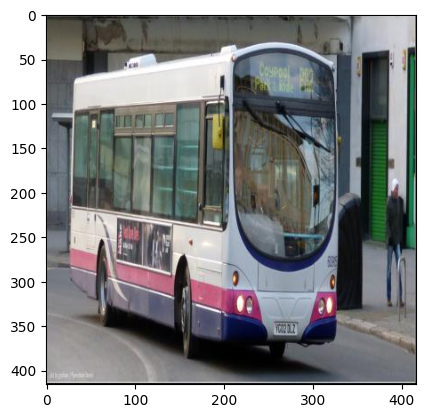

In [21]:
print(f"Class ID: {train_labels[0][0]}")
for box in train_labels[0][0]: print(f"Box Coordinates: {box}")
img = train_features[0]
img = img.permute(1, 2, 0)
print(img.shape)
plt.imshow(img)
plt.show()

In [22]:
# Convert tensor image to correct openCV image format
def tensor_to_cv2_image(tensor):
    # Convert GPU tensor to CPU based
    image = tensor.cpu().numpy() 
    image = (image * 255) # convert to unnormalized pixel values
    image = np.ascontiguousarray(image, np.uint8)
    return image

# Draw boxes on image
def draw_boxes(image, label):
    class_id, x_center, y_center, width, height = label
    
    # Get image dimensions
    image_height, image_width = image.shape[1], image.shape[0]
    
    # Convert normalized coordinates to pixel coordinates
    x_center = int(x_center * image_width)
    y_center = int(y_center * image_height)
    width = int(width * image_width)
    height = int(height * image_height)
    
    # Calculate bounding box corners
    x_min = int(x_center - width / 2)
    y_min = int(y_center - height / 2)
    x_max = int(x_center + width / 2)
    y_max = int(y_center + height / 2)
    
    # Place box coordinates       
    cv.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    cv.putText(image, str(int(class_id)), (x_min, y_min - 10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return image

In [23]:
# Convert image tensor to openCV image
image = tensor_to_cv2_image(img)
print("Image Type:", type(image))
print("Image Shape:", image.shape)

# Draw box on image
image = draw_boxes(image, train_labels[0][0])

Image Type: <class 'numpy.ndarray'>
Image Shape: (416, 416, 3)


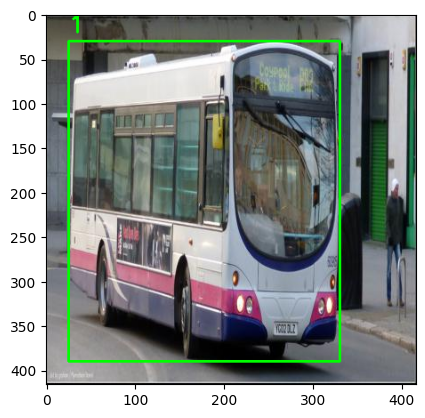

In [24]:
plt.imshow(image)

In [25]:
# NORMALIZE MY TESTING DATA????

# NEXT
    # Create model + loss function & optimizer
    # Train model
    # Test model
        # Test OpenCV live detection
        
        
# NEXT PROJECT IDEA
    # USE CUDA FOR PARALLEL COMPUTING SHIT

In [34]:
def conv_size(size, conv_kernel_size, pool_kernel_size, padding, conv_stride, pool_stride):
    output_size = ((size - conv_kernel_size + 2 * padding) / conv_stride) + 1
    output_size = ((output_size - pool_kernel_size) / pool_stride) + 1
    return output_size

size = conv_size(416, 5, 2, 0, 1, 2)
size = conv_size(size, 5, 2, 0, 1, 2)
size

101.0

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class DetectNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected Layers
        self.fc1 = nn.Linear(16 * 101 * 101, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 5)
        
        # Activation Function
        self.relu = nn.ReLU() # Output: (0,x)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        
        # Flatten 3D tensor to 1D for FFNN
        x = torch.flatten(x, 1)
        
        # Feed forward pass
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [36]:
net = DetectNet()

# 3. Define loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [42]:
# 4. Train the network
for epoch in range(10): # loop dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(norm_trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # Labels: List of batch_size tensors with n classified objects
        # Grab tensor within the labels list
        labels = labels[0]
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        
        # forward + backward + optimze
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print('Finished Training')

ValueError: Expected input batch_size (4) to match target batch_size (1).